# Digits recognition problem. Non CNN solution

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


In [2]:
# Download the MNIST dataset (handwritten digit images with labels)
mnist = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

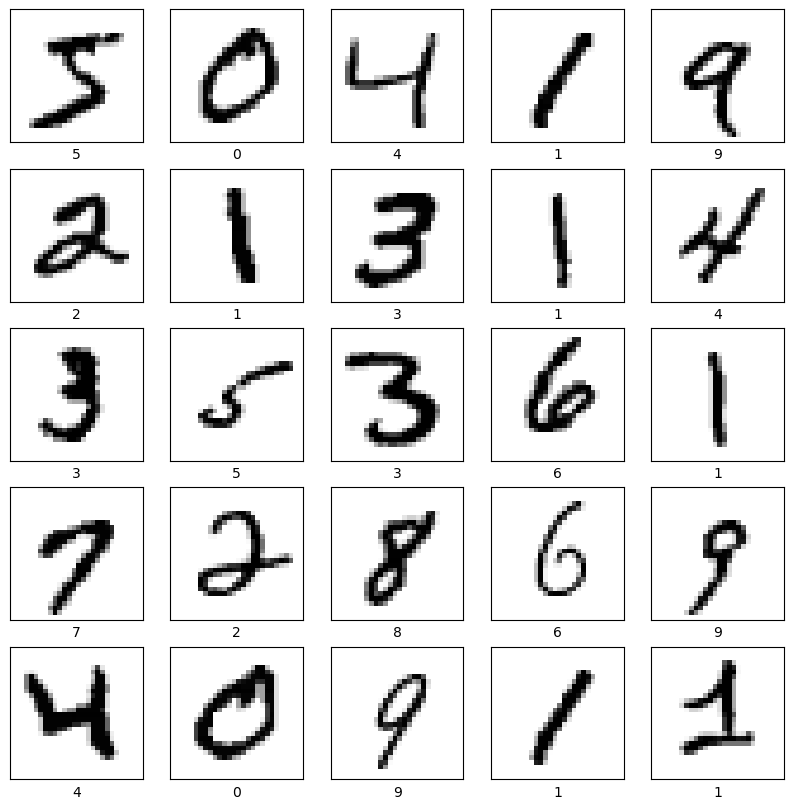

In [3]:
plt.figure(figsize=(10, 10))
for i in range(25):  # Display 25 images
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_images[i], cmap=plt.cm.binary)
    plt.xlabel(training_labels[i])
plt.show()

In [4]:
training_images = training_images / 255.0
test_images = test_images / 255.0

# Reshape the data to include a channel dimension
training_images = training_images.reshape(training_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [6]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),  # 1 = grayscale
    Dense(units=50, activation='relu', input_shape=(28, 28, 1)),
    Dense(units=50, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 50)                39250     
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [8]:
BATCH_SIZE = 32
num_training_images = training_images.shape[0]

history = model.fit(
    training_images, training_labels,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=(training_images, training_labels)
)

Epoch 1/10
1875/1875 [==============================] - 7s 2ms/step - loss: 0.2984 - accuracy: 0.9145 - val_loss: 0.1562 - val_accuracy: 0.9548
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1370 - accuracy: 0.9597 - val_loss: 0.0986 - val_accuracy: 0.9708
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1018 - accuracy: 0.9696 - val_loss: 0.0789 - val_accuracy: 0.9764
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0817 - accuracy: 0.9751 - val_loss: 0.0711 - val_accuracy: 0.9772
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0675 - accuracy: 0.9793 - val_loss: 0.0568 - val_accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0582 - accuracy: 0.9816 - val_loss: 0.0445 - val_accuracy: 0.9859
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0499 - accuracy: 0.9844 - val_loss: 0.0329 - val_accuracy:

In [9]:
model.save('digit_non_CNN.h5')

In [10]:
from tensorflow.keras.models import load_model

model_non_cnn = load_model('digit_non_CNN.h5')

In [11]:
def classify_model_non_cnn(image):
    resized_image = image.resize((28, 28))
    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")
    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = 1 - image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28))
    reshaped_image = reshaped_image.astype(np.float32)

    predictions = model_non_cnn.predict(reshaped_image)
    print(np.trunc(predictions * 100))

    # Get the predicted class index
    predicted_class = np.argmax(predictions)
    return predicted_class

In [12]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        non_cnn_class = classify_model_non_cnn(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

1/1 [==============================] - 0s 44ms/step
[[ 0.  1.  0.  0. 50.  9.  4.  0. 32.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0.  0.  0.  0. 66.  0.  0.  0. 33.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  0.  0.  0. 66.  0.  0.  0. 33.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0. 99.  0.  0.  0.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  0. 99.  0.  0.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  0.  0. 99.  0.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s 14ms/step
[[ 0.  0.  0.  0. 98.  0.  0.  0.  0.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  0.  0.  0.  0. 93.  0.  0.  6.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0.  0.  0.  0.  0. 95.  2.  0.  2.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0.  0.  0.  0.  0. 95.  2.  0.  2.  0.]]
1/1 [==============================] - 0

## Recognizing digits with CNN

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Fourth convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Flattening the 3D output to 1D before feeding it into the dense layer
    layers.Flatten(),
    
    # Dense layers for classification
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')  # For 10 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary to see the architecture and parameters
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 1, 32)         

In [14]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [15]:
BATCH_SIZE = 32
num_training_images = training_images.shape[0]

history = model.fit(
    training_images, training_labels,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=(training_images, training_labels)
)

Epoch 1/10
1875/1875 [==============================] - 11s 4ms/step - loss: 0.2253 - accuracy: 0.9298 - val_loss: 0.0697 - val_accuracy: 0.9788
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0715 - accuracy: 0.9776 - val_loss: 0.0515 - val_accuracy: 0.9837
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.0371 - val_accuracy: 0.9879
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0439 - accuracy: 0.9866 - val_loss: 0.0289 - val_accuracy: 0.9913
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0353 - accuracy: 0.9891 - val_loss: 0.0229 - val_accuracy: 0.9926
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0206 - val_accuracy: 0.9931
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0239 - accuracy: 0.9923 - val_loss: 0.0370 - val_accuracy

In [16]:
model.save('digit_CNN.h5')

In [17]:
model_cnn = load_model('digit_CNN.h5')

In [20]:
classes = [str(i) for i in range(10)]

def classify_model_cnn(image):
    resized_image = image.resize((28, 28))

    # Convert the image to grayscale
    grayscale_image = resized_image.convert("L")

    # Convert the image to a NumPy array
    image_array = np.array(grayscale_image)

    normalized_image = image_array / 255.0
    reshaped_image = np.reshape(normalized_image, (1, 28, 28, 1))
#     reshaped_image = reshaped_image.astype(np.float32)
    predictions = model_cnn.predict(1 - reshaped_image)

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)
    predict_label = classes[predicted_class_index]
    return predict_label

In [ ]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

def paint_and_model():

    width = 200  # canvas width
    height = 200 # canvas height
    center = height//2
    white = (255, 255, 255) # canvas back

    def paint(event):
        x1, y1 = (event.x - 1), (event.y - 1)
        x2, y2 = (event.x + 1), (event.y + 1)
        canvas.create_oval(x1, y1, x2, y2, fill="black",width=15)
        draw.line([x1, y1, x2, y2],fill="black",width=15)

    master = Tk()

    def close_window():
        master.destroy()
        
    def clear_window():
        canvas.delete("all")
        output_image.paste((255, 255, 255), (0, 0, width, height))        
    
    def do_classify():
        cnn_class = classify_model_cnn(output_image)
        non_cnn_class = classify_model_non_cnn(output_image)
        classification_label.config(text=f"NonCNN:{non_cnn_class}, CNN:{cnn_class}")


    # create a tkinter canvas to draw on
    canvas = Canvas(master, width=width, height=height, bg='white')
    canvas.pack()

    # create an empty PIL image and draw object to draw on
    output_image = PIL.Image.new("RGB", (width, height), white)
    draw = ImageDraw.Draw(output_image)
    canvas.pack(expand=YES, fill=BOTH)
    canvas.bind("<B1-Motion>", paint)
    
    classification_label = Label(master, text="", font=("Courier Bold", 15))
    classification_label.pack()

    b1=Button(text="classify",command=do_classify)
    b1.pack(side=LEFT)
    
    button=Button(text="clear",command=clear_window)
    button.pack(side=LEFT)
        
    button=Button(text="close",command=close_window)
    button.pack(side=LEFT)
    
    master.mainloop()
    
paint_and_model()

1/1 [==============================] - 0s 12ms/step
[[ 0.  0. 95.  0.  0.  0.  0.  3.  0.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 3.  0.  0.  0.  0. 92.  2.  0.  1.  0.]]
1/1 [==============================] - 0s 13ms/step
[[ 0.  0.  0. 98.  0.  1.  0.  0.  0.  0.]]
1/1 [==============================] - 0s 12ms/step
[[ 0.  0.  0. 92.  0.  0.  0.  0.  5.  0.]]
1/1 [==============================] - 0s 13ms/step
[[68.  5.  8.  7.  0.  0.  8.  1.  0.  0.]]
